In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "1_raw")
out= os.join(root, "data", "2_intermediate")

In [47]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

In [49]:
## load pluto data as points
pluto= gpd.GeoDataFrame.from_postgis("""SELECT bbl, 
                                               tract2010,
                                               geom_point FROM mappluto_21v3
                                        WHERE landuse IN ('01', '02', '03', '04')""", connection,
                                    geom_col = "geom_point")

In [ ]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



In [ ]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1kiYbPtSYavHQKzyMWtXaLhP-JM2toXRm' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

## Calculate catchment for alarm boxes

In [1]:
firecomp= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Companies/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firecomp

firebat= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Battalions/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firebat

firediv= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Divisions/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firediv

NameError: name 'gpd' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
firebat.plot(ax=ax, color='#6a6a6a', edgecolor='white', linewidth=2)
firediv.plot(ax=ax, color='none', edgecolor='red')

In [ ]:
firevac= pd.read_csv("https://data.cityofnewyork.us/resource/n5xc-7jfa.csv?$limit=100000")
firevac.shape

In [12]:
alarmbox= gpd.read_file("https://data.cityofnewyork.us/resource/v57i-gtxb.geojson?$limit=100000").to_crs(2263)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
firebat.to_crs(2263).plot(ax=ax, color='#6a6a6a', edgecolor='white', linewidth=2)
firediv.to_crs(2263).plot(ax=ax, color='none', edgecolor='red')
alarmbox.plot(ax=ax, color='green', markersize=0.5, alpha = 0.8)

In [ ]:
pluto.head()
#alarmbox

In [ ]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

pluto_borobox= ckdnearest(pluto, alarmbox)

In [ ]:
pluto_borobox.head()

In [ ]:
pluto_borobox.to_csv(os.join(out, "pluto_borobox.csv"))
#pluto_borobox.to_file(os.join(out, "pluto_borobox.geojson"), driver = "GeoJSON")

In [3]:
pluto_borobox= gpd.read_file(os.join(out, "pluto_borobox.geojson"), driver = "GeoJSON")

In [24]:
alarmbox_crop= alarmbox.sort_values(['longitude','latitude']).head(10)
alarmbox_crop
alarmbox_crop.to_file(os.join(out, "alarmbox_crop.geojson"), driver = "GeoJSON")

,location,latitude,zip,borobox,communitydistict,longitude,box_type,citycouncil,borough,geometry
2656,83 AVE & 268 ST,40.74071766,NA,Q6787,QN13,-73.70166495,BARS,23,Queens,POINT (1066921.906 209280.814)
9374,78 AVE & LANGDALE ST,40.75066133,NA,Q6780,QN13,-73.70190486,BARS,23,Queens,POINT (1066843.097 212903.364)
10297,HILLSIDE AVE & 267 ST,40.73871092,11004,Q6786,QN13,-73.70191218,BARS,23,Queens,POINT (1066855.885 208549.466)
8870,82 AVE & 268 ST,40.74276304,NA,Q6789,QN13,-73.70242433,BARS,23,Queens,POINT (1066708.943 210025.291)
8027,79 AVE & 270 ST,40.74860698,NA,Q6783,QN13,-73.70264467,BARS,23,Queens,POINT (1066640.659 212154.205)
7125,80 AVE & 269 ST,40.74663016,11004,Q6779,QN13,-73.70288412,BARS,23,Queens,POINT (1066576.756 211433.765)
5787,81 AVE & 268 ST,40.74454724,11004,Q6788,QN13,-73.70308723,BARS,23,Queens,POINT (1066523.049 210674.705)
8068,77 AVE & HEWLETT ST,40.75355871,NA,Q6461,QN13,-73.70361147,BARS,23,Queens,POINT (1066366.677 213957.362)
5897,HILLSIDE AVE & 265 ST,40.73831906,11004,Q6798,QN13,-73.70373634,BARS,23,Queens,POINT (1066350.859 208404.985)
9585,79 AVE & 268 ST,40.74821885,11004,Q6768,QN13,-73.70445068,BARS,23,Queens,POINT (1066140.732 212011.104)


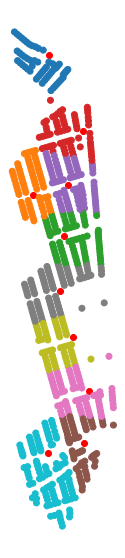

In [25]:
## create map
fig, ax = plt.subplots(figsize=(20, 10))
alarmbox_crop.plot(ax=ax, color = 'red')
pluto_borobox[pluto_borobox['borobox'].isin(alarmbox_crop['borobox'].tolist())]\
        .reset_index().plot(column="borobox", ax=ax)
plt.axis('off');
plt.savefig('assigned_points_firebox.pdf')

## Create Census Tract Weights

In [3]:
pluto_borobox = gpd.read_file(os.join(out, "pluto_borobox.geojson"))

In [234]:
plutobox_ct= pd.merge(pluto_borobox.loc[:, ["bbl", "location", "borobox", "box_type", "latitude", "longitude"]],
         pluto.loc[:, ["bbl", "tract2010"]], on = "bbl")

plutobox_ct['boroct2010']= plutobox_ct['bbl'].str[0] + plutobox_ct['tract2010'].astype(str).str.replace(".", "", regex = False).str.pad(width = 6, side = "right",
                                                                                                                      fillchar = "0")
plutobox_ct.head()

# manual recode of borobox tract values
plutobox_ct.loc[plutobox_ct["borobox"]=="X4609", 'boroct2010']= '2027402'
plutobox_ct.loc[plutobox_ct["borobox"]=="Q1605", 'boroct2010']= '4107201'
plutobox_ct.loc[plutobox_ct["borobox"]=="Q2058", 'boroct2010']= '4088400'
plutobox_ct.loc[plutobox_ct["borobox"]=="R3845", 'boroct2010']= '5015603'
plutobox_ct.loc[plutobox_ct["borobox"]=="R4515", 'boroct2010']= '5024800'

In [235]:
# load acs data (to check census tract recoding)
csv = drive.CreateFile({'id': '17PvjIPesTzugausfzMi7rTiXahTiHaH1'})
csv.GetContentFile('acs_data.csv')  

acs= pd.read_csv('acs_data.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
acs= acs.loc[acs['year']==2019]
acs.head()

,geofips,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,...,pctnhblack,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter
21721,36005000100,6864,10599.550,0.647574,6345,519,103,3322,3392,47,...,52.462121,0.262238,2.636946,0.0,0.276807,0.509907,NaN,NaN,NaN,NaN
21722,36005000200,4532,24481.190,0.185122,2193,2339,1134,862,1605,931,...,20.300088,0.000000,1.654898,0.0,1.323919,0.000000,52.459016,47.540984,11.997019,18.181818
21723,36005000400,5516,18537.140,0.297565,2810,2706,1071,1319,2362,764,...,22.915156,0.000000,2.193619,0.0,0.163162,1.341552,79.040157,20.959843,1.860921,4.906542
21724,36005001600,5825,31101.490,0.187290,2422,3403,1546,1399,1978,902,...,34.695279,0.000000,1.098712,0.0,0.858369,0.429185,12.430238,87.569762,11.415525,12.514484
21725,36005001900,3141,4877.152,0.644023,1583,1558,898,1052,1111,80,...,29.831264,0.000000,2.292264,0.0,0.700414,1.782872,10.565338,89.434662,9.638554,10.777202


In [236]:
acs['geofips_recode']= acs['geofips'].astype(str).str[2:]
acs['geofips_recode']= np.select([acs['geofips_recode'].str[0:3] == '005',
                                 acs['geofips_recode'].str[0:3] == '047',
                                 acs['geofips_recode'].str[0:3] == '061',
                                 acs['geofips_recode'].str[0:3] == '081',
                                 acs['geofips_recode'].str[0:3] == '085'],
                                ['2' + acs['geofips_recode'].str[3:],
                                '3' + acs['geofips_recode'].str[3:],
                                 '1' + acs['geofips_recode'].str[3:],
                                 '4' + acs['geofips_recode'].str[3:],
                                 '5' + acs['geofips_recode'].str[3:]])

print(acs.loc[acs['geofips_recode'].str.len() < 7, 'geofips_recode'].head())
acs.loc[acs['geofips_recode'].str.len() < 7, 'geofips_recode']= \
acs.loc[acs['geofips_recode'].str.len() < 7, 'geofips_recode'].str.pad(width = 7, fillchar = "0", side = "right")

acs[['geofips_recode', 'geofips']]

Series([], Name: geofips_recode, dtype: object)


,geofips_recode,geofips
21721,2000100,36005000100
21722,2000200,36005000200
21723,2000400,36005000400
21724,2001600,36005001600
21725,2001900,36005001900
...,...,...
23883,5030302,36085030302
23884,5031901,36085031901
23885,5031902,36085031902
23886,5032300,36085032300


In [237]:
acs.loc[(acs['geofips'].astype(str) == '36047033600'), :]

,geofips,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,...,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,geofips_recode
22340,36047033600,4443,16720.04,0.265729,2185,2258,839,749,2109,746,...,0.0,7.089804,0.0,0.0,2.025658,49.618321,50.381679,4.898219,5.808081,3033600


In [238]:
# this is not true
# assert (acs["geofips"].str.len() == 9).all()
assert (acs["geofips_recode"].str.len() == 7).all()
print(acs.loc[acs["geofips"].astype(str).str.len() != 9].shape[0])
acs.loc[acs["geofips"].astype(str).str.len() != 9].head()

2167


,geofips,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,...,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,geofips_recode
21721,36005000100,6864,10599.550,0.647574,6345,519,103,3322,3392,47,...,0.262238,2.636946,0.0,0.276807,0.509907,NaN,NaN,NaN,NaN,2000100
21722,36005000200,4532,24481.190,0.185122,2193,2339,1134,862,1605,931,...,0.000000,1.654898,0.0,1.323919,0.000000,52.459016,47.540984,11.997019,18.181818,2000200
21723,36005000400,5516,18537.140,0.297565,2810,2706,1071,1319,2362,764,...,0.000000,2.193619,0.0,0.163162,1.341552,79.040157,20.959843,1.860921,4.906542,2000400
21724,36005001600,5825,31101.490,0.187290,2422,3403,1546,1399,1978,902,...,0.000000,1.098712,0.0,0.858369,0.429185,12.430238,87.569762,11.415525,12.514484,2001600
21725,36005001900,3141,4877.152,0.644023,1583,1558,898,1052,1111,80,...,0.000000,2.292264,0.0,0.700414,1.782872,10.565338,89.434662,9.638554,10.777202,2001900


In [239]:
# merge pluto (w/ borobox and census tract to ACS data with recoded geofips var)
pluto_acs= plutobox_ct.merge(acs, left_on = "boroct2010", right_on = "geofips_recode", 
                             how = "outer",
                             indicator = True)
pluto_acs.head()

,bbl,location,borobox,box_type,latitude,longitude,tract2010,boroct2010,geofips,totpop,...,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,geofips_recode,_merge
0,3042270037,BELMONT AVE & MILFORD ST,B1826,ERS,40.67338539,-73.87680041,1194,3119400,36047119400,4892,...,1.287817,0.0,0.0,0.0,31.165919,68.834081,33.781764,44.082519,3119400,both
1,3040220001,BELMONT AVE & ATKINS AVE,B1804,ERS,40.67311965,-73.87864502,1194,3119400,36047119400,4892,...,1.287817,0.0,0.0,0.0,31.165919,68.834081,33.781764,44.082519,3119400,both
2,3040220005,BELMONT AVE & ATKINS AVE,B1804,ERS,40.67311965,-73.87864502,1194,3119400,36047119400,4892,...,1.287817,0.0,0.0,0.0,31.165919,68.834081,33.781764,44.082519,3119400,both
3,3040220006,BELMONT AVE & ATKINS AVE,B1804,ERS,40.67311965,-73.87864502,1194,3119400,36047119400,4892,...,1.287817,0.0,0.0,0.0,31.165919,68.834081,33.781764,44.082519,3119400,both
4,3040220119,PITKIN AVE & BERRIMAN ST,B1824,ERS,40.67425552,-73.8798826,1194,3119400,36047119400,4892,...,1.287817,0.0,0.0,0.0,31.165919,68.834081,33.781764,44.082519,3119400,both


In [240]:
# check merge results
pluto_acs["_merge"].value_counts()

both          764560
right_only        57
left_only          0
Name: _merge, dtype: int64

In [241]:
pluto_acs.loc[pluto_acs["_merge"]=="right_only", "geofips_recode"].value_counts()
# note: bronx tract 001 is Rikers Island
# i think these are ok, spot checked some--many seem like parks
# top two with population seem like rikers and part of roosevelt island?
pluto_acs.loc[pluto_acs["_merge"]=="right_only", :].sort_values('totpop', ascending = False)

,bbl,location,borobox,box_type,latitude,longitude,tract2010,boroct2010,geofips,totpop,...,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,geofips_recode,_merge
764560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36005000100,6864,...,2.636946,0.000000,0.276807,0.509907,NaN,NaN,NaN,NaN,2000100,right_only
764585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36061023802,6086,...,26.043378,0.000000,0.000000,2.678278,4.954955,95.045045,9.966216,10.189573,1023802,right_only
764586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36061024000,2009,...,3.135889,1.095072,0.000000,0.497760,NaN,NaN,NaN,NaN,1024000,right_only
764565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36005031900,633,...,6.003160,0.000000,0.000000,1.737757,NaN,NaN,NaN,NaN,2031900,right_only
764614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36085001800,588,...,3.061224,0.000000,1.020408,5.782313,2.209945,97.790055,8.287293,8.474576,5001800,right_only
764598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36081042600,477,...,6.079665,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,4042600,right_only
764561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36005002400,155,...,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,2002400,right_only
764590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36081005000,49,...,0.000000,0.000000,0.000000,0.000000,32.258065,67.741935,0.000000,0.000000,4005000,right_only
764612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36081138502,39,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,4138502,right_only
764576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36047085200,26,...,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,NaN,3085200,right_only


In [244]:
# comparison census tracts, check it merges with comparison census tracts
ct_comp= pd.read_csv(os.join(inp, "NYC_Census_Tracts_for_2010_US_Census.csv"))
ct_comp["BoroCT2010"]= ct_comp["BoroCT2010"].astype(str)

ct_comp_merge= plutobox_ct.merge(ct_comp, left_on = "boroct2010", right_on = "BoroCT2010",
                                 how = "outer",
                                 indicator = True)
ct_comp.head()
ct_comp_merge["_merge"].value_counts()

both          764560
right_only        55
left_only          0
Name: _merge, dtype: int64

## Count of buildings by census tract

In [248]:
plutobox_ct_count= plutobox_ct.value_counts(['boroct2010', 'borobox']).rename('count').reset_index()
plutobox_ct_count

,boroct2010,borobox,count
0,3070201,B4116,1614
1,3033600,B3520,836
2,2051600,X4607,694
3,5020803,R4329,661
4,5017007,R3387,660
...,...,...,...
18620,3031100,B0918,1
18621,3031300,B1579,1
18622,3031900,B1044,1
18623,3032500,B3762,1


In [249]:
plutobox_ct_count= pd.merge(plutobox_ct_count,
         plutobox_ct_count.groupby('boroct2010', as_index = False)["count"].sum()\
         .rename({'count':'total'}, axis = 1), on = "boroct2010")
plutobox_ct_count['wgt']= plutobox_ct_count['count'].div(plutobox_ct_count['total'])

In [250]:
plutobox_ct_count

,boroct2010,borobox,count,total,wgt
0,3070201,B4116,1614,1876,0.860341
1,3070201,B3994,228,1876,0.121535
2,3070201,B4103,34,1876,0.018124
3,3033600,B3520,836,913,0.915663
4,3033600,B3522,77,913,0.084337
...,...,...,...,...,...
18620,3035000,B3564,1,2,0.500000
18621,3035601,B3387,1,1,1.000000
18622,3025500,B0365,1,2,0.500000
18623,3025500,B0368,1,2,0.500000


In [251]:
## save census tract, borobox, weight crosswalk
plutobox_ct_count.to_csv(os.join(out, "ct_box_xwalk.csv"))